In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

import scripts.TextAnalysis as ta
import sklearn.cluster as cluster
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



# Cluster a User's Tweets 

In this problem we are going to cluster the tweets of a single user.  Our goal is to determine different topics this person tweets about.  

The user is social media influencer Kim Kardashian, with screen name is KimKardashian.

In [3]:
#load data
df = pd.read_csv("data/tweets_KimKardashian.csv")
df = df[ ['screen_name', 'text']]
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
n0 = len(df)
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0
nclean = len(df)
print(f"{n0} tweets, {nclean} clean tweets")

3231 tweets, 3179 clean tweets


#### the term frequency embedding of the tweets.  

In [4]:
tf_vectorizer = CountVectorizer(min_df=5, stop_words='english')
tf_embedding = tf_vectorizer.fit_transform(df.text_clean)
tf_feature_names = tf_vectorizer.get_feature_names()

nvocab = len(tf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")

3179 tweets, 936 words in vocabulary


#### LDA model to the tweets with 3 topics.  top words in each topic 

In [7]:
lda = LatentDirichletAllocation(n_components=3, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf_embedding)

In [8]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 4
print("LDA topics\n")
display_topics(lda, tf_feature_names, num_top_words)

LDA topics

Topic 1
kkwbeauty, kkwfragrance, shop, u0001f90d
Topic 2
skims, collection, happy, shop
Topic 3
kimkardashian, kuwtk, love, new


#### Use the fit LDA model to convert the tf embedding into a topic vector embedding for the tweets.

In [9]:
embedding_lda = lda.transform(tf_embedding)
print(f"shape of embedding_lda is {embedding_lda.shape}")

shape of embedding_lda is (3179, 3)


####the k-means clusters of the LDA topic vectors using 3 clusters.  

In [15]:
n_clusters  = 3
kmeans_label_lda = cluster.KMeans(n_clusters=n_clusters).fit_predict(embedding_lda)
df['kmeans_label_lda'] = [str(x) for x in kmeans_label_lda]

#### Plot the word cloud for each cluster.  

In [4]:
def kmeans_wordcloud_userhist(df, cluster_label_column,stopwords):
    print(cluster_label_column)
    for k in np.sort(df[cluster_label_column].unique()):
        s=df[df[cluster_label_column]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)
     
        print(f"\n\tCluster {k} {cluster_label_column} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
#         plt.subplot(1,2,1)
#         ax = sns.histplot(data = s, x = 'screen_name')
#         plt.xticks(rotation=45)
#         plt.ylabel("Number of tweets")
#         plt.xlabel("Screen name")

        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1



kmeans_label_lda

	Cluster 0 kmeans_label_lda has 1311 tweets


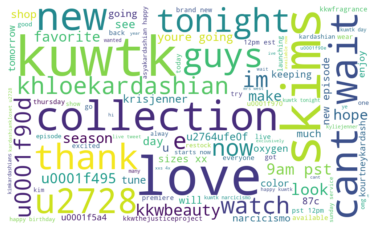


	Cluster 1 kmeans_label_lda has 1014 tweets


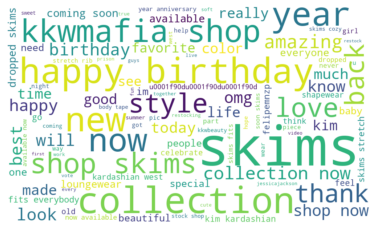


	Cluster 2 kmeans_label_lda has 854 tweets


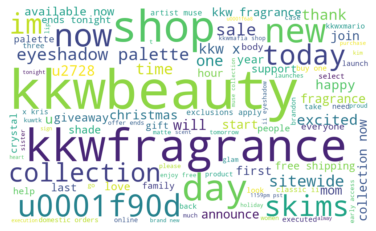

1

In [18]:
stopwords = set(STOPWORDS)
stopwords.add("kimkardashian")
cluster_label_column= 'kmeans_label_lda'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )

# Finding User Communities by Clustering Tweets (50 points)

In [2]:
#load data
df = pd.read_csv("data/tweets_multiple_users.csv")
df = df[ ['screen_name', 'text']]
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
n0 = len(df)
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0
nclean = len(df)
print(f"{n0} tweets, {nclean} clean tweets")

16003 tweets, 15867 clean tweets


#### Calculate the term frequency inverse document frequency (tf-idf) embedding of the tweets. 

In [6]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_embedding = tfidf_vectorizer.fit_transform(df.text_clean)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nvocab = len(tfidf_feature_names)
print(f"{nclean} tweets, {nvocab} words in vocabulary")

15867 tweets, 4281 words in vocabulary


#### Calculate the UMAP embedding of the tf-idf embedding

In [5]:
umap_tfidf_embedding = umap.UMAP(n_components=2, metric='hellinger').fit_transform(tfidf_embedding)

D:\Anaconda\lib\site-packages\umap\umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 9608 edges.
It has only fully disconnected 453 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


#### Calculate the k-means clusters of the umap embedding using 4 clusters.  

In [7]:
#your answer here
df['umap_tfidf_x'] = umap_tfidf_embedding[:,0]
df['umap_tfidf_y'] = umap_tfidf_embedding[:,1]
n_clusters = 4

kmeans_label_umap = cluster.KMeans(n_clusters=n_clusters).fit_predict(np.nan_to_num(umap_tfidf_embedding))
df['kmeans_label_umap'] = [str(x) for x in kmeans_label_umap]

#### scatter plots of the UMAP embedding: 

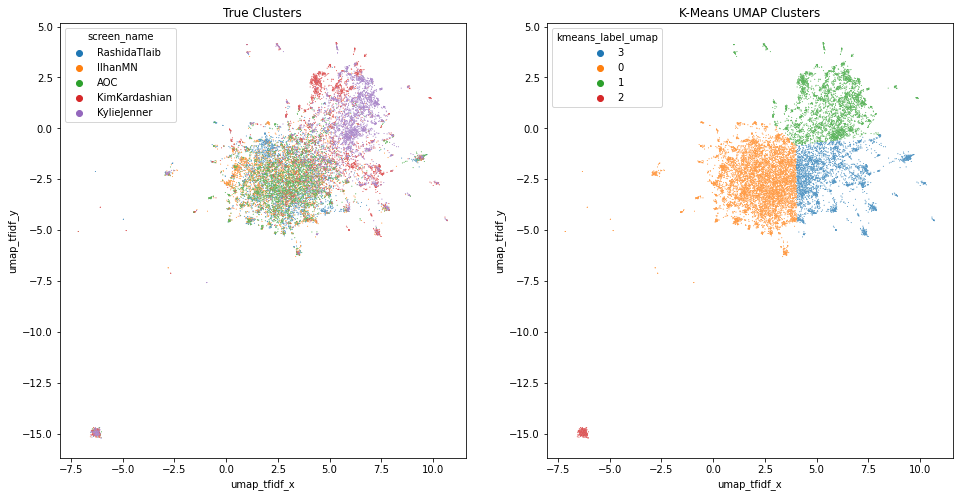

In [9]:
#your answer here
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(data=df, x="umap_tfidf_x", y="umap_tfidf_y", hue="screen_name", s=1)
plt.title("True Clusters")

ax2 = plt.subplot(1,2,2)
sns.scatterplot(data=df, x="umap_tfidf_x", y="umap_tfidf_y", hue="kmeans_label_umap", s=1)
plt.title("K-Means UMAP Clusters");
plt.show()

#### Plot the word cloud and screen name histogram in each cluster.  

In [10]:
def kmeans_wordcloud_userhist(df, cluster_label_column,stopwords):
    print(cluster_label_column)
    for k in np.sort(df[cluster_label_column].unique()):
        s=df[df[cluster_label_column]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)
     
        print(f"\n\tCluster {k} {cluster_label_column} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
        plt.subplot(1,2,1)
        ax = sns.histplot(data = s, x = 'screen_name')
        plt.xticks(rotation=45)
        plt.ylabel("Number of tweets")
        plt.xlabel("Screen name")

        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1


kmeans_label_umap

	Cluster 0 kmeans_label_umap has 8051 tweets


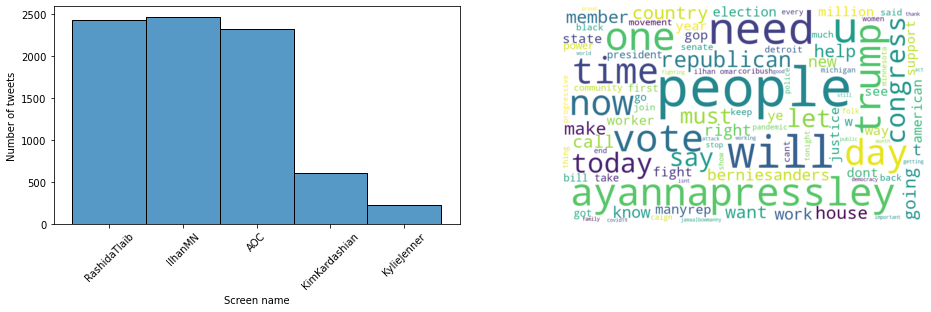


	Cluster 1 kmeans_label_umap has 3790 tweets


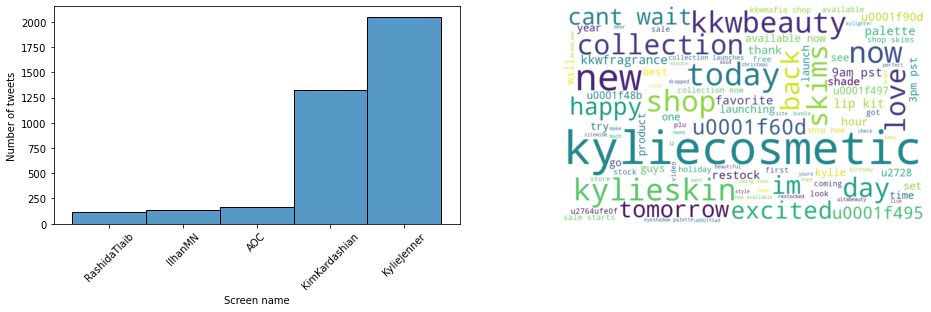


	Cluster 2 kmeans_label_umap has 407 tweets


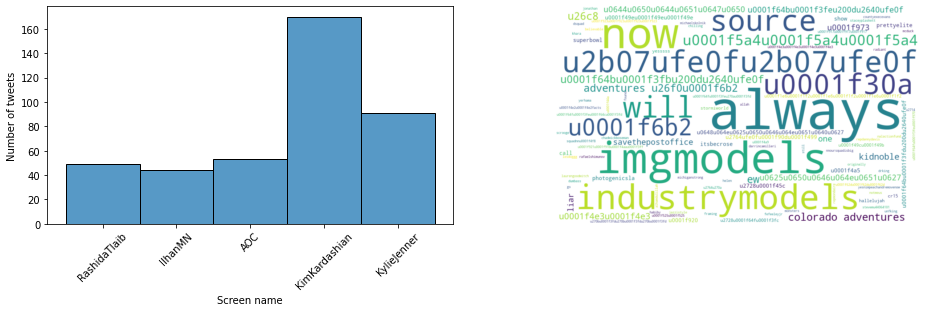


	Cluster 3 kmeans_label_umap has 3619 tweets


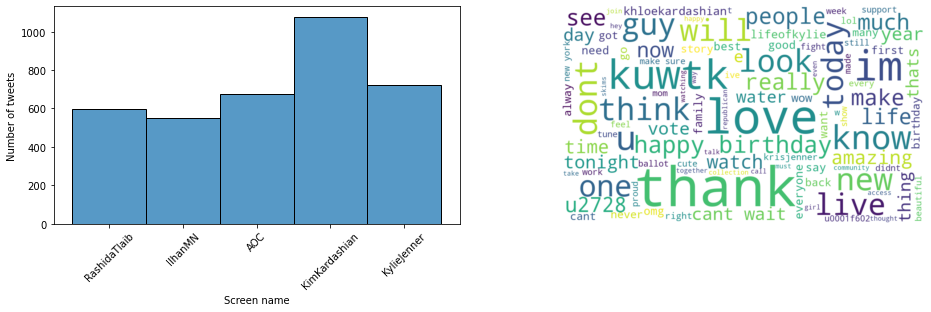

1

In [11]:
#your answer here
stopwords = set(STOPWORDS)
[stopwords.add(x) for x in df.screen_name.unique().tolist()]
cluster_label_column= 'kmeans_label_umap'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )
